In [111]:
import os
import csv
import glob
import json
import numpy as np
np.set_printoptions(threshold = np.inf)
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, metrics, callbacks

In [ ]:
MAX_SPLIT_SIZE = 24

SAVE_DIR = f"results/"
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

In [ ]:
def read_csv(csv_path):
    datas = list()

    with open(csv_path, "r") as f:
        r = csv.reader(f)

        for i, R in enumerate(r):
            if i == 0: continue

            if i == 1:
                next_peak = int(float(R[2]))
                continue

            peak = int(float(R[2]))
            gain = next_peak - peak
            gain_percent = (next_peak - peak) / peak * 100

            tmp = {
                "year" : int(R[0]),
                "month" : int(R[1]),
                "peak" : peak,
                "price" : int(R[4]),
                "steam_online" : int(R[5]),
                "gain" : gain,
                "gain_percent" : gain_percent
            }
            datas.append(tmp)

            next_peak = peak

    return list(reversed(datas))

def standardize_data(datas):
    items = list(datas[-1].keys())

    mean_items = {
        I : np.average([D[I] for D in datas]) for I in items
    }

    std_items = {
        I : np.std([D[I] for D in datas]) for I in items
    }

    sd_datas = list()
    for D in datas:
        tmp = dict()
        for I in items:
            if std_items[I] == 0:
                tmp[I] = 0
            else:
                tmp[I] = (D[I] - mean_items[I]) / std_items[I]
        sd_datas.append(tmp)

    return sd_datas, mean_items, std_items

In [ ]:
csgo_datas = read_csv("csgo_dataset.csv")
sd_csgo_datas, mean_csgo, std_csgo = standardize_data(csgo_datas)

dota2_datas = read_csv("Dota2_dataset.csv")
sd_dota2_datas, mean_dota2, std_dota2 = standardize_data(dota2_datas)

rust_datas = read_csv("Rust_dataset.csv")
sd_rust_datas, mean_rust, std_rust = standardize_data(rust_datas)

# データセットの作成(初めの一回だけ)

学習データ，検証データの作成

In [ ]:
inputs = list()
teacher_signals = list()

for i in range(MAX_SPLIT_SIZE, len(sd_csgo_datas)):
    tmp_inputs = list()
    tmp_teacher_signals = list()

    for D in sd_csgo_datas[i - MAX_SPLIT_SIZE : i]:
        tmp = list()
        tmp.append( D["peak"] )
        tmp.append( D["price"] )
        tmp.append( D["steam_online"] )

        tmp_inputs.append(tmp)
        tmp_teacher_signals.append(D["gain_percent"])

    inputs.append( tmp_inputs )
    teacher_signals.append( tmp_teacher_signals )

inputs = np.array(inputs).astype(np.float32)
teacher_signals = np.array(teacher_signals).astype(np.float32)

train_index, test_index = train_test_split(list(range(len(inputs))), test_size = 0.1)
train_inputs, train_teacher_signals = inputs[train_index], teacher_signals[train_index]
test_inputs, test_teacher_signals = inputs[test_index], teacher_signals[test_index]

#
train_inputs.shape, train_teacher_signals.shape, test_inputs.shape, test_teacher_signals.shape

Rustデータ(検証用)の作成

In [ ]:
rust_inputs = list()
rust_teacher_signals = list()

for i in range(MAX_SPLIT_SIZE, len(sd_rust_datas)):
    tmp_inputs = list()
    tmp_teacher_signals = list()

    for D in sd_rust_datas[i - MAX_SPLIT_SIZE : i]:
        tmp = list()
        tmp.append( D["peak"] )
        tmp.append( D["price"] )
        tmp.append( D["steam_online"] )

        tmp_inputs.append(tmp)
        tmp_teacher_signals.append(D["gain_percent"])

    rust_inputs.append( tmp_inputs )
    rust_teacher_signals.append( tmp_teacher_signals )

rust_inputs = np.array(rust_inputs).astype(np.float32)
rust_teacher_signals = np.array(rust_teacher_signals).astype(np.float32)

#
rust_inputs.shape, rust_teacher_signals.shape

Dota2データ(検証用)の作成

In [ ]:
dota2_inputs = list()
dota2_teacher_signals = list()

for i in range(MAX_SPLIT_SIZE, len(sd_dota2_datas)):
    tmp_inputs = list()
    tmp_teacher_signals = list()

    for D in sd_dota2_datas[i - MAX_SPLIT_SIZE : i]:
        tmp = list()
        tmp.append( D["peak"] )
        tmp.append( D["price"] )
        tmp.append( D["steam_online"] )

        tmp_inputs.append(tmp)
        tmp_teacher_signals.append(D["gain_percent"])

    dota2_inputs.append( tmp_inputs )
    dota2_teacher_signals.append( tmp_teacher_signals )

dota2_inputs = np.array(dota2_inputs).astype(np.float32)
dota2_teacher_signals = np.array(dota2_teacher_signals).astype(np.float32)

#
dota2_inputs.shape, dota2_teacher_signals.shape

In [ ]:
# np.save("train_inputs", train_inputs)
# np.save("train_teacher_signals", train_teacher_signals)
# np.save("test_inputs", test_inputs)
# np.save("test_teacher_signals", test_teacher_signals)
# np.save("rust_inputs", rust_inputs)
# np.save("rust_teacher_signals", rust_teacher_signals)
# np.save("dota2_inputs", dota2_inputs)
# np.save("dota2_teacher_signals", dota2_teacher_signals)
# with open("train_index.json", "w") as f:
#     json.dump(train_index, f)
# with open("test_index.json", "w") as f:
#     json.dump(test_index, f)

# データセットの読み込み

In [ ]:
train_inputs = np.load("train_inputs.npy")
train_teacher_signals = np.load("train_teacher_signals.npy")
test_inputs = np.load("test_inputs.npy")
test_teacher_signals = np.load("test_teacher_signals.npy")
rust_inputs = np.load("rust_inputs.npy")
rust_teacher_signals = np.load("rust_teacher_signals.npy")
dota2_inputs = np.load("dota2_inputs.npy")
dota2_teacher_signals = np.load("dota2_teacher_signals.npy")
with open("train_index.json", "r") as f:
    train_index = json.load(f)
with open("test_index.json", "r") as f:
    test_index = json.load(f)


# 学習

In [ ]:
class MyMetric(metrics.Metric):
    def __init__(self, name = 'MyMetric', **kwargs):
        super(MyMetric, self).__init__(name = name)
        self.s = self.add_weight('s', initializer = 'zeros')

    def update_state(self, y_true, y_pred, sample_weight = None):
        tmp = tf.math.reduce_mean(tf.math.pow(y_true[:, -1] - y_pred[:, -1], 2))
        self.s.assign_add(tmp)

    def reset_state(self):
        self.s.assign(0)

    def result(self):
        return self.s

## model_4

return_sequence : True

batch_size : フルバッチ

中間層 : 1層

In [ ]:
return_sequence = True
batch_size = len(train_index)
num_middle = 4

In [ ]:
for i in tqdm(range(MAX_SPLIT_SIZE, 0, -1)):

    target_dir = f"{SAVE_DIR}LSTM{num_middle}_{return_sequence}_{batch_size}_{i}/"
    if os.path.exists(f"{target_dir}history.json"):
        continue
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)

    tmp_train_inputs = train_inputs[:, -i:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -i:]
    tmp_test_inputs = test_inputs[:, -i:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -i:]

    def build_model():
        input = layers.Input(shape = tmp_train_inputs.shape[1:])
        x = layers.LSTM(units = 1024, activation = "relu", return_sequences = return_sequence)(input)
        x = layers.LSTM(units = 1024, activation = "relu", return_sequences = return_sequence)(x)
        x = layers.LSTM(units = 512, activation = "relu", return_sequences = return_sequence)(x)
        x = layers.LSTM(units = 512, activation = "relu", return_sequences = return_sequence)(x)
        output = layers.Dense(units = 1, activation = "linear")(x)

        return models.Model(input, output)

    mcp = callbacks.ModelCheckpoint(filepath = f"{target_dir}model.h5",
                                    monitor = "val_loss",
                                    mode = "min",
                                    save_best_only = True)
    model = build_model()
    model.compile(loss = losses.MeanSquaredError(),
                  optimizer = optimizers.Adam(learning_rate = 0.0001),
                  metrics = [MyMetric()])
    history = model.fit(x = tmp_train_inputs, y = tmp_train_teacher_signals, batch_size = batch_size, epochs = 1000,
                        validation_data = (tmp_test_inputs, tmp_test_teacher_signals), callbacks = [mcp], verbose = False)

    # 学習データに対する予測
    tmp = list()
    for i, TI in enumerate(train_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_train_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_train_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Train")
    ax.legend()
    plt.savefig(f"{target_dir}train_result.png")
    plt.close()

    # 検証データに対する予測
    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Test")
    ax.legend()
    plt.savefig(f"{target_dir}test_result.png")
    plt.close()

    # Dota2データに対する予測
    tmp = list()
    for i, TI in enumerate(range(len(dota2_inputs))):
        tmp.append([f'{dota2_datas[TI]["year"]}/{dota2_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(dota2_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = dota2_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("Dota2")
    ax.legend()
    plt.savefig(f"{target_dir}Dota2_result.png")
    plt.close()

    # rustデータに対する予測
    tmp = list()
    for i, TI in enumerate(range(len(rust_inputs))):
        tmp.append([f'{rust_datas[TI]["year"]}/{rust_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(rust_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = rust_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("Rust")
    ax.legend()
    plt.savefig(f"{target_dir}Rust_result.png")
    plt.close()

    with open(f"{target_dir}/history.json", "w") as f:
        json.dump(history.history, f)

## model_3

In [ ]:
return_sequence = True
batch_size = len(train_index)
num_middle = 4

In [ ]:
for i in tqdm(range(MAX_SPLIT_SIZE, 0, -1)):

    target_dir = f"{SAVE_DIR}RNN{num_middle}_{return_sequence}_{batch_size}_{i}/"
    if os.path.exists(f"{target_dir}history.json"):
        continue
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)

    tmp_train_inputs = train_inputs[:, -i:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -i:]
    tmp_test_inputs = test_inputs[:, -i:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -i:]

    def build_model():
        input = layers.Input(shape = tmp_train_inputs.shape[1:])
        x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = return_sequence)(input)
        x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = return_sequence)(x)
        x = layers.SimpleRNN(units = 512, activation = "relu", return_sequences = return_sequence)(x)
        x = layers.SimpleRNN(units = 512, activation = "relu", return_sequences = return_sequence)(x)
        output = layers.Dense(units = 1, activation = "linear")(x)

        return models.Model(input, output)

    mcp = callbacks.ModelCheckpoint(filepath = f"{target_dir}model.h5",
                                    monitor = "val_loss",
                                    mode = "min",
                                    save_best_only = True)
    model = build_model()
    model.compile(loss = losses.MeanSquaredError(),
                  optimizer = optimizers.Adam(learning_rate = 0.0001),
                  metrics = [MyMetric()])
    history = model.fit(x = tmp_train_inputs, y = tmp_train_teacher_signals, batch_size = batch_size, epochs = 1000,
                        validation_data = (tmp_test_inputs, tmp_test_teacher_signals), callbacks = [mcp], verbose = False)

    # 学習データに対する予測
    tmp = list()
    for i, TI in enumerate(train_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_train_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_train_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Train")
    ax.legend()
    plt.savefig(f"{target_dir}train_result.png")
    plt.close()

    # 検証データに対する予測
    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Test")
    ax.legend()
    plt.savefig(f"{target_dir}test_result.png")
    plt.close()

    # Dota2データに対する予測
    tmp = list()
    for i, TI in enumerate(range(len(dota2_inputs))):
        tmp.append([f'{dota2_datas[TI]["year"]}/{dota2_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(dota2_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = dota2_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("Dota2")
    ax.legend()
    plt.savefig(f"{target_dir}Dota2_result.png")
    plt.close()

    # rustデータに対する予測
    tmp = list()
    for i, TI in enumerate(range(len(rust_inputs))):
        tmp.append([f'{rust_datas[TI]["year"]}/{rust_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(rust_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = rust_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("Rust")
    ax.legend()
    plt.savefig(f"{target_dir}Rust_result.png")
    plt.close()

    with open(f"{target_dir}/history.json", "w") as f:
        json.dump(history.history, f)

## model_2

In [ ]:
return_sequence = True
batch_size = len(train_index)
num_middle = 1

In [ ]:
for i in tqdm(range(MAX_SPLIT_SIZE, 0, -1)):

    target_dir = f"{SAVE_DIR}LSTM{num_middle}_{return_sequence}_{batch_size}_{i}/"
    if os.path.exists(f"{target_dir}history.json"):
        continue
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)

    tmp_train_inputs = train_inputs[:, -i:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -i:]
    tmp_test_inputs = test_inputs[:, -i:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -i:]

    def build_model():
        input = layers.Input(shape = tmp_train_inputs.shape[1:])
        x = layers.LSTM(units = 1024, activation = "relu", return_sequences = return_sequence)(input)
        output = layers.Dense(units = 1, activation = "linear")(x)

        return models.Model(input, output)

    mcp = callbacks.ModelCheckpoint(filepath = f"{target_dir}model.h5",
                                    monitor = "val_loss",
                                    mode = "min",
                                    save_best_only = True)
    model = build_model()
    model.compile(loss = losses.MeanSquaredError(),
                  optimizer = optimizers.Adam(learning_rate = 0.0001),
                  metrics = [MyMetric()])
    history = model.fit(x = tmp_train_inputs, y = tmp_train_teacher_signals, batch_size = batch_size, epochs = 1000,
                        validation_data = (tmp_test_inputs, tmp_test_teacher_signals), callbacks = [mcp], verbose = False)

    # 学習データに対する予測
    tmp = list()
    for i, TI in enumerate(train_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_train_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_train_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Train")
    ax.legend()
    plt.savefig(f"{target_dir}train_result.png")
    plt.close()

    # 検証データに対する予測
    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Test")
    ax.legend()
    plt.savefig(f"{target_dir}test_result.png")
    plt.close()

    # Dota2データに対する予測
    tmp = list()
    for i, TI in enumerate(range(len(dota2_inputs))):
        tmp.append([f'{dota2_datas[TI]["year"]}/{dota2_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(dota2_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = dota2_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("Dota2")
    ax.legend()
    plt.savefig(f"{target_dir}Dota2_result.png")
    plt.close()

    # rustデータに対する予測
    tmp = list()
    for i, TI in enumerate(range(len(rust_inputs))):
        tmp.append([f'{rust_datas[TI]["year"]}/{rust_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(rust_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = rust_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("Rust")
    ax.legend()
    plt.savefig(f"{target_dir}Rust_result.png")
    plt.close()

    with open(f"{target_dir}/history.json", "w") as f:
        json.dump(history.history, f)

In [ ]:
for i in tqdm(range(MAX_SPLIT_SIZE, 0, -1)):

    target_dir = f"{SAVE_DIR}LSTM{num_middle}_{return_sequence}_{batch_size}_{i}/"
    if os.path.exists(f"{target_dir}history.json"):
        continue
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)

    tmp_train_inputs = train_inputs[:, -i:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -1]
    tmp_test_inputs = test_inputs[:, -i:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -1]

    def build_model():
        input = layers.Input(shape = tmp_train_inputs.shape[1:])
        x = layers.LSTM(units = 1024, activation = "relu", return_sequences = True)(input)
        x = layers.LSTM(units = 1024, activation = "relu", return_sequences = True)(x)
        x = layers.LSTM(units = 512, activation = "relu", return_sequences = True)(x)
        x = layers.LSTM(units = 512, activation = "relu", return_sequences = return_sequence)(x)
        output = layers.Dense(units = 1, activation = "linear")(x)

        return models.Model(input, output)

    mcp = callbacks.ModelCheckpoint(filepath = f"{target_dir}model.h5",
                                    monitor = "val_loss",
                                    mode = "min",
                                    save_best_only = True)
    model = build_model()
    model.compile(loss = losses.MeanSquaredError(),
                  optimizer = optimizers.Adam(learning_rate = 0.0001),
                  metrics = [MyMetric()])
    history = model.fit(x = tmp_train_inputs, y = tmp_train_teacher_signals, batch_size = batch_size, epochs = 10,
                        validation_data = (tmp_test_inputs, tmp_test_teacher_signals), callbacks = [mcp], verbose = False)

    # 学習データに対する予測
    tmp = list()
    for i, TI in enumerate(train_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_train_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_train_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Train")
    ax.legend()
    plt.savefig(f"{target_dir}train_result.png")
    plt.close()

    # 検証データに対する予測
    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Test")
    ax.legend()
    plt.savefig(f"{target_dir}test_result.png")
    plt.close()

    # Dota2データに対する予測
    tmp = list()
    for i, TI in enumerate(range(len(dota2_inputs))):
        tmp.append([f'{dota2_datas[TI]["year"]}/{dota2_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(dota2_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p#[:, -1, 0]
    t = dota2_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t#[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("Dota2")
    ax.legend()
    plt.savefig(f"{target_dir}Dota2_result.png")
    plt.close()

    # rustデータに対する予測
    tmp = list()
    for i, TI in enumerate(range(len(rust_inputs))):
        tmp.append([f'{rust_datas[TI]["year"]}/{rust_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(rust_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p#[:, -1, 0]
    t = rust_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t#[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("Rust")
    ax.legend()
    plt.savefig(f"{target_dir}Rust_result.png")
    plt.close()

    with open(f"{target_dir}/history.json", "w") as f:
        json.dump(history.history, f)

# RNN2層で試す

In [ ]:
return_sequence = True
batch_size = len(train_index)
num_middle = 2

In [ ]:
for i in tqdm(range(MAX_SPLIT_SIZE, 0, -1)):

    target_dir = f"{SAVE_DIR}RNN{num_middle}_{return_sequence}_{batch_size}_{i}/"
    if os.path.exists(f"{target_dir}history.json"):
        continue
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)

    tmp_train_inputs = train_inputs[:, -i:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -i:]
    tmp_test_inputs = test_inputs[:, -i:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -i:]

    def build_model():
        input = layers.Input(shape = tmp_train_inputs.shape[1:])
        x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = return_sequence)(input)
        x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = return_sequence)(x)
        output = layers.Dense(units = 1, activation = "linear")(x)

        return models.Model(input, output)

    mcp = callbacks.ModelCheckpoint(filepath = f"{target_dir}model.h5",
                                    monitor = "val_loss",
                                    mode = "min",
                                    save_best_only = True)
    model = build_model()
    model.compile(loss = losses.MeanSquaredError(),
                  optimizer = optimizers.Adam(learning_rate = 0.0001),
                  metrics = [MyMetric()])
    history = model.fit(x = tmp_train_inputs, y = tmp_train_teacher_signals, batch_size = batch_size, epochs = 1000,
                        validation_data = (tmp_test_inputs, tmp_test_teacher_signals), callbacks = [mcp], verbose = False)

    # 学習データに対する予測
    tmp = list()
    for i, TI in enumerate(train_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_train_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_train_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Train")
    ax.legend()
    plt.savefig(f"{target_dir}train_result.png")
    plt.close()

    # 検証データに対する予測
    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Test")
    ax.legend()
    plt.savefig(f"{target_dir}test_result.png")
    plt.close()

    # Dota2データに対する予測
    tmp = list()
    for i, TI in enumerate(range(len(dota2_inputs))):
        tmp.append([f'{dota2_datas[TI]["year"]}/{dota2_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(dota2_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = dota2_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("Dota2")
    ax.legend()
    plt.savefig(f"{target_dir}Dota2_result.png")
    plt.close()

    # rustデータに対する予測
    tmp = list()
    for i, TI in enumerate(range(len(rust_inputs))):
        tmp.append([f'{rust_datas[TI]["year"]}/{rust_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(rust_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = rust_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("Rust")
    ax.legend()
    plt.savefig(f"{target_dir}Rust_result.png")
    plt.close()

    with open(f"{target_dir}/history.json", "w") as f:
        json.dump(history.history, f)

# RNN3層で試す

In [ ]:
return_sequence = True
batch_size = len(train_index)
num_middle = 3

In [ ]:
for i in tqdm(range(MAX_SPLIT_SIZE, 0, -1)):

    target_dir = f"{SAVE_DIR}RNN{num_middle}_{return_sequence}_{batch_size}_{i}/"
    if os.path.exists(f"{target_dir}history.json"):
        continue
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)

    tmp_train_inputs = train_inputs[:, -i:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -i:]
    tmp_test_inputs = test_inputs[:, -i:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -i:]

    def build_model():
        input = layers.Input(shape = tmp_train_inputs.shape[1:])
        x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = return_sequence)(input)
        x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = return_sequence)(x)
        x = layers.SimpleRNN(units = 512, activation = "relu", return_sequences = return_sequence)(x)
        output = layers.Dense(units = 1, activation = "linear")(x)

        return models.Model(input, output)

    mcp = callbacks.ModelCheckpoint(filepath = f"{target_dir}model.h5",
                                    monitor = "val_loss",
                                    mode = "min",
                                    save_best_only = True)
    model = build_model()
    model.compile(loss = losses.MeanSquaredError(),
                  optimizer = optimizers.Adam(learning_rate = 0.0001),
                  metrics = [MyMetric()])
    history = model.fit(x = tmp_train_inputs, y = tmp_train_teacher_signals, batch_size = batch_size, epochs = 1000,
                        validation_data = (tmp_test_inputs, tmp_test_teacher_signals), callbacks = [mcp], verbose = False)

    # 学習データに対する予測
    tmp = list()
    for i, TI in enumerate(train_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_train_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_train_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Train")
    ax.legend()
    plt.savefig(f"{target_dir}train_result.png")
    plt.close()

    # 検証データに対する予測
    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Test")
    ax.legend()
    plt.savefig(f"{target_dir}test_result.png")
    plt.close()

    # Dota2データに対する予測
    tmp = list()
    for i, TI in enumerate(range(len(dota2_inputs))):
        tmp.append([f'{dota2_datas[TI]["year"]}/{dota2_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(dota2_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = dota2_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("Dota2")
    ax.legend()
    plt.savefig(f"{target_dir}Dota2_result.png")
    plt.close()

    # rustデータに対する予測
    tmp = list()
    for i, TI in enumerate(range(len(rust_inputs))):
        tmp.append([f'{rust_datas[TI]["year"]}/{rust_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(rust_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = rust_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("Rust")
    ax.legend()
    plt.savefig(f"{target_dir}Rust_result.png")
    plt.close()

    with open(f"{target_dir}/history.json", "w") as f:
        json.dump(history.history, f)

# 推論結果グラフ作成

In [ ]:
dir = "./results/RNN4_True_85_"
STEPS = [3, 24]
# STEPS = [10]
Single_sa = list()

for S in STEPS:

    tmp_train_inputs = train_inputs[:, -S:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -S:]
    tmp_test_inputs = test_inputs[:, -S:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -S:]

    model = models.load_model(f"{dir}{S}/model.h5", {"MyMetric" : MyMetric()})
    preds = model.predict(tmp_test_inputs)
    if S == 3:
        a = preds
    else:
        b = preds

    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs, batch_size = len(tmp_test_inputs))
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    
    fig = plt.figure(figsize = (8, 3))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):

        # ax.scatter(i, t[I], color = "blue", marker='o', alpha=0.8, s=100)
        ax.scatter(i, t[I], s=100, alpha=1, linewidths=1, c='white', edgecolors='b')
        # ax.scatter(i, t[I], color = "blue")
        ax.scatter(i, p[I], color = "red", marker = "x", s = 100)
    
    ax.scatter(i, t[I],  s=100, alpha=1, linewidths=1, c='white', edgecolors='b', label = "answer")
    ax.scatter(i, p[I], color = "red", label = "pred", marker = "x", s = 100)
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)", fontsize = 14)
    ax.set_xlabel("Test date", fontsize = 14)
    ax.set_title(f"month = {S}")
    ax.legend()
    ax.grid()
    plt.show()

    # for i in range(len(p)):
    for i, (_, I) in enumerate(tmp):
        # Single_sa.append(abs(p[I] - t[I]))
        print(f"誤差{i}番目:{abs(p[I] - t[I])}")

# 教師信号と推論結果の誤差をもとめる

In [ ]:
dir = "./results/RNN4_True_85_"
STEPS = list(range(1, 25))
# STEPS = [10]
val_mse_rnn_4 = list()

for S in STEPS:

    tmp_train_inputs = train_inputs[:, -S:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -S:]
    tmp_test_inputs = test_inputs[:, -S:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -S:]

    model = models.load_model(f"{dir}{S}/model.h5", {"MyMetric" : MyMetric()})
    preds = model.predict(tmp_test_inputs)
    if S == 3:
        a = preds
    else:
        b = preds

    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs, batch_size = len(tmp_test_inputs))
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    val_mse_rnn_4.append( losses.MeanSquaredError()(p, t) )

    
    fig = plt.figure(figsize = (8, 3))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):

        # ax.scatter(i, t[I], color = "blue", marker='o', alpha=0.8, s=100)
        ax.scatter(i, t[I], s=100, alpha=1, linewidths=1, c='white', edgecolors='b')
        # ax.scatter(i, t[I], color = "blue")
        ax.scatter(i, p[I], color = "red", marker = "x", s = 100)
    
    ax.scatter(i, t[I],  s=100, alpha=1, linewidths=1, c='white', edgecolors='b', label = "answer")
    ax.scatter(i, p[I], color = "red", label = "pred", marker = "x", s = 100)
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)", fontsize = 14)
    ax.set_xlabel("Test date", fontsize = 14)
    ax.set_title(f"month = {S}")
    ax.legend()
    ax.grid()
    # plt.close() 
    plt.show()

    # for i in range(len(p)):
    # for i, (_, I) in enumerate(tmp):
    #     # Single_sa.append(abs(p[I] - t[I]))
    #     print(f"誤差{i}番目:{abs(p[I] - t[I])}")

In [ ]:
dir = "./results/RNN1_True_85_"
STEPS = list(range(1, 25))
# STEPS = [10]
val_mse_rnn_1 = list()

for S in STEPS:

    tmp_train_inputs = train_inputs[:, -S:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -S:]
    tmp_test_inputs = test_inputs[:, -S:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -S:]

    model = models.load_model(f"{dir}{S}/model.h5", {"MyMetric" : MyMetric()})
    preds = model.predict(tmp_test_inputs, verbose = False)
    if S == 3:
        a = preds
    else:
        b = preds

    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs, batch_size = len(tmp_test_inputs))
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    val_mse_rnn_1.append( losses.MeanSquaredError()(p, t) )

    
    fig = plt.figure(figsize = (8, 3))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):

        # ax.scatter(i, t[I], color = "blue", marker='o', alpha=0.8, s=100)
        ax.scatter(i, t[I], s=100, alpha=1, linewidths=1, c='white', edgecolors='b')
        # ax.scatter(i, t[I], color = "blue")
        ax.scatter(i, p[I], color = "red", marker = "x", s = 100)
    
    ax.scatter(i, t[I],  s=100, alpha=1, linewidths=1, c='white', edgecolors='b', label = "answer")
    ax.scatter(i, p[I], color = "red", label = "pred", marker = "x", s = 100)
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)", fontsize = 14)
    ax.set_xlabel("Test date", fontsize = 14)
    ax.set_title(f"month = {S}")
    ax.legend()
    ax.grid()
    plt.close() 
    # plt.show()

    # for i in range(len(p)):
    # for i, (_, I) in enumerate(tmp):
    #     # Single_sa.append(abs(p[I] - t[I]))
    #     print(f"誤差{i}番目:{abs(p[I] - t[I])}")

In [ ]:
dir = "./results/LSTM1_True_85_"
STEPS = list(range(1, 25))
# STEPS = [10]
val_mse_lstm_1 = list()

for S in STEPS:

    tmp_train_inputs = train_inputs[:, -S:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -S:]
    tmp_test_inputs = test_inputs[:, -S:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -S:]

    model = models.load_model(f"{dir}{S}/model.h5", {"MyMetric" : MyMetric()})
    preds = model.predict(tmp_test_inputs, verbose = False)
    if S == 3:
        a = preds
    else:
        b = preds

    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs, batch_size = len(tmp_test_inputs))
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    val_mse_lstm_1.append( losses.MeanSquaredError()(p, t) )

    
    fig = plt.figure(figsize = (8, 3))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):

        # ax.scatter(i, t[I], color = "blue", marker='o', alpha=0.8, s=100)
        ax.scatter(i, t[I], s=100, alpha=1, linewidths=1, c='white', edgecolors='b')
        # ax.scatter(i, t[I], color = "blue")
        ax.scatter(i, p[I], color = "red", marker = "x", s = 100)
    
    ax.scatter(i, t[I],  s=100, alpha=1, linewidths=1, c='white', edgecolors='b', label = "answer")
    ax.scatter(i, p[I], color = "red", label = "pred", marker = "x", s = 100)
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)", fontsize = 14)
    ax.set_xlabel("Test date", fontsize = 14)
    ax.set_title(f"month = {S}")
    ax.legend()
    ax.grid()
    # plt.close() 
    plt.show()

    # for i in range(len(p)):
    # for i, (_, I) in enumerate(tmp):
    #     # Single_sa.append(abs(p[I] - t[I]))
    #     print(f"誤差{i}番目:{abs(p[I] - t[I])}")

In [ ]:
dir = "./results/RNN2_True_85_"
STEPS = list(range(1, 25))
# STEPS = [10]
val_mse_rnn_2 = list()

for S in STEPS:

    tmp_train_inputs = train_inputs[:, -S:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -S:]
    tmp_test_inputs = test_inputs[:, -S:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -S:]

    model = models.load_model(f"{dir}{S}/model.h5", {"MyMetric" : MyMetric()})
    preds = model.predict(tmp_test_inputs, verbose = False)
    if S == 3:
        a = preds
    else:
        b = preds

    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs, batch_size = len(tmp_test_inputs))
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    val_mse_rnn_2.append( losses.MeanSquaredError()(p, t) )

    
    fig = plt.figure(figsize = (8, 3))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):

        # ax.scatter(i, t[I], color = "blue", marker='o', alpha=0.8, s=100)
        ax.scatter(i, t[I], s=100, alpha=1, linewidths=1, c='white', edgecolors='b')
        # ax.scatter(i, t[I], color = "blue")
        ax.scatter(i, p[I], color = "red", marker = "x", s = 100)
    
    ax.scatter(i, t[I],  s=100, alpha=1, linewidths=1, c='white', edgecolors='b', label = "answer")
    ax.scatter(i, p[I], color = "red", label = "pred", marker = "x", s = 100)
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)", fontsize = 14)
    ax.set_xlabel("Test date", fontsize = 14)
    ax.set_title(f"month = {S}")
    ax.legend()
    ax.grid()
    # plt.close() 
    plt.show()

    # for i in range(len(p)):
    # for i, (_, I) in enumerate(tmp):
    #     # Single_sa.append(abs(p[I] - t[I]))
    #     print(f"誤差{i}番目:{abs(p[I] - t[I])}")

In [ ]:
dir = "./results/RNN3_True_85_"
STEPS = list(range(1, 25))
# STEPS = [10]
val_mse_rnn_3 = list()

for S in STEPS:

    tmp_train_inputs = train_inputs[:, -S:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -S:]
    tmp_test_inputs = test_inputs[:, -S:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -S:]

    model = models.load_model(f"{dir}{S}/model.h5", {"MyMetric" : MyMetric()})
    preds = model.predict(tmp_test_inputs, verbose = False)
    if S == 3:
        a = preds
    else:
        b = preds

    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs, batch_size = len(tmp_test_inputs))
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    val_mse_rnn_3.append( losses.MeanSquaredError()(p, t) )

    
    fig = plt.figure(figsize = (8, 3))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):

        # ax.scatter(i, t[I], color = "blue", marker='o', alpha=0.8, s=100)
        ax.scatter(i, t[I], s=100, alpha=1, linewidths=1, c='white', edgecolors='b')
        # ax.scatter(i, t[I], color = "blue")
        ax.scatter(i, p[I], color = "red", marker = "x", s = 100)
    
    ax.scatter(i, t[I],  s=100, alpha=1, linewidths=1, c='white', edgecolors='b', label = "answer")
    ax.scatter(i, p[I], color = "red", label = "pred", marker = "x", s = 100)
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)", fontsize = 14)
    ax.set_xlabel("Test date", fontsize = 14)
    ax.set_title(f"month = {S}")
    ax.legend()
    ax.grid()
    # plt.close() 
    plt.show()

    # for i in range(len(p)):
    # for i, (_, I) in enumerate(tmp):
    #     # Single_sa.append(abs(p[I] - t[I]))
    #     print(f"誤差{i}番目:{abs(p[I] - t[I])}")

In [ ]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot()
ax.plot(list(range(1, MAX_SPLIT_SIZE + 1)), (val_mse_rnn_1), color="red" , linestyle="dashed", label="RNN_1")
ax.plot(list(range(1, MAX_SPLIT_SIZE + 1)), (val_mse_lstm_1), color="blue", linestyle="solid", label="LSTM_1")
ax.legend()
ax.set_ylabel("val MSE",fontsize=15)
ax.set_xlabel("k", fontsize=15)
ax.grid()

In [ ]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot()

# for i in range(len(24)):
ax.plot(list(range(1, MAX_SPLIT_SIZE + 1)), (val_mse_rnn_1), color="red", linestyle="dashed", label="RNN_1")
ax.plot(list(range(1, MAX_SPLIT_SIZE + 1)), (val_mse_rnn_4), color="orange", linestyle="dotted", label="RNN_4")
# ax.plot(val_mse_rnn_1[1], color="red", marker="o" ,linestyle="dashed")
# ax.plot(val_mse_rnn_4[1], color="orange", marker="x", linestyle="dotted")

ax.legend()
ax.set_ylabel("val MSE",fontsize=15)
ax.set_xlabel("k", fontsize=15)
ax.grid()
ax.set_yscale("log")
# ax.show()

In [ ]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot()
ax.plot(list(range(1, MAX_SPLIT_SIZE + 1)), (val_mse_rnn_1), color="red", linestyle="dashed", label="RNN_1")
ax.plot(list(range(1, MAX_SPLIT_SIZE + 1)), (val_mse_rnn_2), color="blue", linestyle="solid", label="RNN_2")
ax.plot(list(range(1, MAX_SPLIT_SIZE + 1)), (val_mse_rnn_3), color="m", linestyle="dashdot", label="RNN_3")
ax.plot(list(range(1, MAX_SPLIT_SIZE + 1)), (val_mse_rnn_4), color="orange", linestyle="dotted", label="RNN_4")



ax.legend()
ax.set_ylabel("val MSE",fontsize=15)
ax.set_xlabel("k", fontsize=15)
ax.grid()
ax.set_yscale("log")

In [ ]:
for i in range(24):
    fig = plt.figure(figsize = (6, 4))
    ax = fig.add_subplot()

    # for i in range(len(24)):
    ax.plot(list(range(1, MAX_SPLIT_SIZE + 1)), (val_mse_rnn_1), color="red", linestyle="dashed", label="RNN_1")
    ax.plot(list(range(1, MAX_SPLIT_SIZE + 1)), (val_mse_rnn_4), color="orange", linestyle="dotted", label="RNN_4")
    # ax.plot(val_mse_rnn_1[1], color="red", marker="o" ,linestyle="dashed")
    # ax.plot(val_mse_rnn_4[1], color="orange", marker="x", linestyle="dotted")
    ax.scatter(list(range(1, MAX_SPLIT_SIZE + 1))[i], (val_mse_rnn_1)[i], marker="o")
    ax.scatter(list(range(1, MAX_SPLIT_SIZE + 1))[i], (val_mse_rnn_4)[i], marker="x")
    

    ax.legend()
    ax.set_ylabel("val MSE",fontsize=15)
    ax.set_xlabel("k", fontsize=15)
    ax.grid()
    ax.set_yscale("log")
    plt.show()
    plt.close()

In [ ]:

fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot()

# for i in range(len(24)):
ax.plot(list(range(1, MAX_SPLIT_SIZE + 1)), (val_mse_rnn_1), color="red", linestyle="dashed", label="RNN_1")
ax.plot(list(range(1, MAX_SPLIT_SIZE + 1)), (val_mse_rnn_4), color="orange", linestyle="dotted", label="RNN_4")
# ax.plot(val_mse_rnn_1[1], color="red", marker="o" ,linestyle="dashed")
# ax.plot(val_mse_rnn_4[1], color="orange", marker="x", linestyle="dotted")
ax.scatter(list(range(1, MAX_SPLIT_SIZE + 1))[21], (val_mse_rnn_1)[i], marker="o")
ax.scatter(list(range(1, MAX_SPLIT_SIZE + 1))[15], (val_mse_rnn_4)[i], marker="x")


ax.legend()
ax.set_ylabel("val MSE",fontsize=15)
ax.set_xlabel("k", fontsize=15)
ax.grid()
ax.set_yscale("log")
plt.show()
plt.close()

# 2013から2021を学習データとして2022を予測する  

In [ ]:
inputs = list()
teacher_signals = list()

for i in range(MAX_SPLIT_SIZE, len(sd_csgo_datas)):
    tmp_inputs = list()
    tmp_teacher_signals = list()

    for D in sd_csgo_datas[i - MAX_SPLIT_SIZE : i]:
        tmp = list()
        tmp.append( D["peak"] )
        tmp.append( D["price"] )
        tmp.append( D["steam_online"] )

        tmp_inputs.append(tmp)
        tmp_teacher_signals.append(D["gain_percent"])

    inputs.append( tmp_inputs )
    teacher_signals.append( tmp_teacher_signals )

inputs = np.array(inputs).astype(np.float32)
teacher_signals = np.array(teacher_signals).astype(np.float32)

train_inputs = inputs[:-10]
train_teacher_signals = teacher_signals[:-10]
test_inputs = inputs[-10:]
test_teacher_signals = teacher_signals[-10:]

train_index = list(range(len(inputs)))[:-10]
test_index = list(range(len(inputs)))[-10:]

In [104]:
return_sequence = True
batch_size = len(train_index)
num_middle = 4

In [ ]:
for i in tqdm(range(MAX_SPLIT_SIZE, 0, -1)):

    target_dir = f"{SAVE_DIR}RNN{num_middle}_{return_sequence}_{batch_size}_{i}_last_month/"
    if os.path.exists(f"{target_dir}history.json"):
        continue
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)

    tmp_train_inputs = train_inputs[:, -i:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -i:]
    tmp_test_inputs = test_inputs[:, -i:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -i:]

    def build_model():
        input = layers.Input(shape = tmp_train_inputs.shape[1:])
        x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = return_sequence)(input)
        x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = return_sequence)(x)
        x = layers.SimpleRNN(units = 512, activation = "relu", return_sequences = return_sequence)(x)
        x = layers.SimpleRNN(units = 512, activation = "relu", return_sequences = return_sequence)(x)
        output = layers.Dense(units = 1, activation = "linear")(x)

        return models.Model(input, output)

    mcp = callbacks.ModelCheckpoint(filepath = f"{target_dir}model.h5",
                                    monitor = "val_loss",
                                    mode = "min",
                                    save_best_only = True)
    model = build_model()
    model.compile(loss = losses.MeanSquaredError(),
                  optimizer = optimizers.Adam(learning_rate = 0.0001),
                  metrics = [MyMetric()])
    history = model.fit(x = tmp_train_inputs, y = tmp_train_teacher_signals, batch_size = batch_size, epochs = 1000,
                        validation_data = (tmp_test_inputs, tmp_test_teacher_signals), callbacks = [mcp], verbose = False)

    # 学習データに対する予測
    tmp = list()
    for i, TI in enumerate(train_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_train_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_train_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Train")
    ax.legend()
    plt.savefig(f"{target_dir}train_result.png")
    plt.close()

    # 検証データに対する予測
    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Test")
    ax.legend()
    plt.savefig(f"{target_dir}test_result.png")
    plt.close()

    with open(f"{target_dir}/history.json", "w") as f:
        json.dump(history.history, f)

In [106]:
return_sequence = True
batch_size = len(train_index)
num_middle = 1

In [107]:
for i in tqdm(range(MAX_SPLIT_SIZE, 0, -1)):

    target_dir = f"{SAVE_DIR}RNN{num_middle}_{return_sequence}_{batch_size}_{i}_last_month/"
    if os.path.exists(f"{target_dir}history.json"):
        continue
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)

    tmp_train_inputs = train_inputs[:, -i:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -i:]
    tmp_test_inputs = test_inputs[:, -i:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -i:]

    def build_model():
        input = layers.Input(shape = tmp_train_inputs.shape[1:])
        x = layers.SimpleRNN(units = 1024, activation = "relu", return_sequences = return_sequence)(input)
        output = layers.Dense(units = 1, activation = "linear")(x)

        return models.Model(input, output)

    mcp = callbacks.ModelCheckpoint(filepath = f"{target_dir}model.h5",
                                    monitor = "val_loss",
                                    mode = "min",
                                    save_best_only = True)
    model = build_model()
    model.compile(loss = losses.MeanSquaredError(),
                  optimizer = optimizers.Adam(learning_rate = 0.0001),
                  metrics = [MyMetric()])
    history = model.fit(x = tmp_train_inputs, y = tmp_train_teacher_signals, batch_size = batch_size, epochs = 1000,
                        validation_data = (tmp_test_inputs, tmp_test_teacher_signals), callbacks = [mcp], verbose = False)

    # 学習データに対する予測
    tmp = list()
    for i, TI in enumerate(train_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_train_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_train_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Train")
    ax.legend()
    plt.savefig(f"{target_dir}train_result.png")
    plt.close()

    # 検証データに対する予測
    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Test")
    ax.legend()
    plt.savefig(f"{target_dir}test_result.png")
    plt.close()

    with open(f"{target_dir}/history.json", "w") as f:
        json.dump(history.history, f)

  0%|          | 0/24 [00:00<?, ?it/s]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step


  4%|▍         | 1/24 [00:44<16:58, 44.28s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 22ms/step


  8%|▊         | 2/24 [01:27<16:02, 43.73s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step


 12%|█▎        | 3/24 [02:09<15:03, 43.00s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 4/24 [02:50<14:04, 42.23s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 15ms/step


 21%|██        | 5/24 [03:31<13:08, 41.53s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 6/24 [04:11<12:17, 40.98s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 7/24 [04:50<11:30, 40.63s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 8/24 [05:29<10:37, 39.85s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 14ms/step


 38%|███▊      | 9/24 [06:05<09:39, 38.63s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 14ms/step


 42%|████▏     | 10/24 [06:40<08:45, 37.56s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 11/24 [07:14<07:53, 36.45s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 14ms/step


 50%|█████     | 12/24 [07:47<07:04, 35.40s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 13/24 [08:18<06:14, 34.07s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 14/24 [08:50<05:35, 33.51s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 15ms/step


 62%|██████▎   | 15/24 [09:20<04:52, 32.51s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 14ms/step


 67%|██████▋   | 16/24 [09:49<04:12, 31.57s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step


 71%|███████   | 17/24 [10:18<03:34, 30.62s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 12ms/step


 75%|███████▌  | 18/24 [10:50<03:06, 31.15s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 19/24 [11:22<02:36, 31.21s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step


 83%|████████▎ | 20/24 [11:53<02:04, 31.12s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 12ms/step


 88%|████████▊ | 21/24 [12:21<01:31, 30.42s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 22/24 [12:48<00:58, 29.45s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 13ms/step


 96%|█████████▌| 23/24 [13:15<00:28, 28.64s/it]/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 15ms/step


100%|██████████| 24/24 [13:40<00:00, 34.17s/it]


# LSTM 1層

In [108]:
return_sequence = True
batch_size = len(train_index)
num_middle = 1

In [109]:
for i in tqdm(range(MAX_SPLIT_SIZE, 0, -1)):

    target_dir = f"{SAVE_DIR}LSTM{num_middle}_{return_sequence}_{batch_size}_{i}_last_month/"
    if os.path.exists(f"{target_dir}history.json"):
        continue
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)

    tmp_train_inputs = train_inputs[:, -i:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -i:]
    tmp_test_inputs = test_inputs[:, -i:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -i:]

    def build_model():
        input = layers.Input(shape = tmp_train_inputs.shape[1:])
        x = layers.LSTM(units = 1024, activation = "relu", return_sequences = return_sequence)(input)
        output = layers.Dense(units = 1, activation = "linear")(x)

        return models.Model(input, output)

    mcp = callbacks.ModelCheckpoint(filepath = f"{target_dir}model.h5",
                                    monitor = "val_loss",
                                    mode = "min",
                                    save_best_only = True)
    model = build_model()
    model.compile(loss = losses.MeanSquaredError(),
                  optimizer = optimizers.Adam(learning_rate = 0.0001),
                  metrics = [MyMetric()])
    history = model.fit(x = tmp_train_inputs, y = tmp_train_teacher_signals, batch_size = batch_size, epochs = 1000,
                        validation_data = (tmp_test_inputs, tmp_test_teacher_signals), callbacks = [mcp], verbose = False)

    # 学習データに対する予測
    tmp = list()
    for i, TI in enumerate(train_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_train_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_train_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (15, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] if i % 6 == 0 else "" for i, T in enumerate(tmp)])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Train")
    ax.legend()
    plt.savefig(f"{target_dir}train_result.png")
    plt.close()

    # 検証データに対する予測
    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs)
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    fig = plt.figure(figsize = (10, 5))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):
        ax.scatter(i, p[I], color = "red")
        ax.scatter(i, t[I], color = "blue")
    ax.scatter(i, p[I], color = "red", label = "pred")
    ax.scatter(i, t[I], color = "blue", label = "answer")
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)")
    ax.set_xlabel("Year/Month")
    ax.set_title("CSGO Test")
    ax.legend()
    plt.savefig(f"{target_dir}test_result.png")
    plt.close()

    with open(f"{target_dir}/history.json", "w") as f:
        json.dump(history.history, f)

  0%|          | 0/24 [00:00<?, ?it/s]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 21ms/step


  4%|▍         | 1/24 [01:39<38:16, 99.86s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 21ms/step


  8%|▊         | 2/24 [02:59<32:13, 87.87s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 3/24 [04:24<30:15, 86.45s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 4/24 [05:52<29:02, 87.11s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 19ms/step


 21%|██        | 5/24 [07:16<27:13, 85.95s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 6/24 [08:39<25:32, 85.16s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 7/24 [10:02<23:55, 84.41s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 8/24 [11:26<22:30, 84.39s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 9/24 [12:47<20:49, 83.33s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 10/24 [14:02<18:49, 80.65s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 11/24 [15:20<17:16, 79.74s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 21ms/step


 50%|█████     | 12/24 [16:39<15:54, 79.51s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 13/24 [17:55<14:22, 78.40s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 14/24 [19:04<12:36, 75.66s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 16ms/step


 62%|██████▎   | 15/24 [20:05<10:42, 71.38s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 16/24 [21:03<08:57, 67.13s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 15ms/step


 71%|███████   | 17/24 [21:58<07:24, 63.57s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 18/24 [22:57<06:12, 62.09s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 14ms/step


 79%|███████▉  | 19/24 [24:08<05:23, 64.76s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 20/24 [25:32<04:42, 70.73s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 21/24 [26:19<03:10, 63.60s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 12ms/step


 92%|█████████▏| 22/24 [27:15<02:02, 61.12s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step


 96%|█████████▌| 23/24 [27:51<00:53, 53.77s/it]

/home/yryo1005/.conda/envs/py39_tf215/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 13ms/step


100%|██████████| 24/24 [28:29<00:00, 71.22s/it]


# データセットを変えた

In [119]:
return_sequence = True
batch_size = len(train_index)
num_middle = 4

1/1 [==============================] - 0s 12ms/step


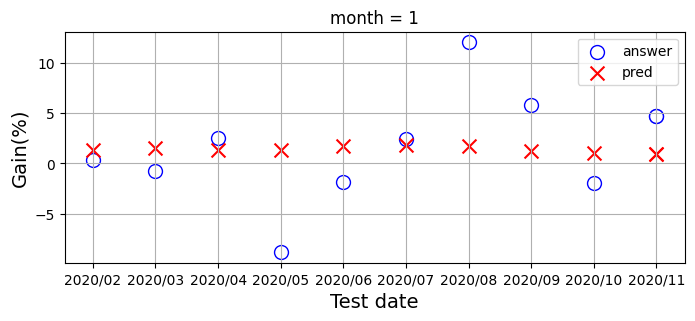

1/1 [==============================] - 0s 13ms/step


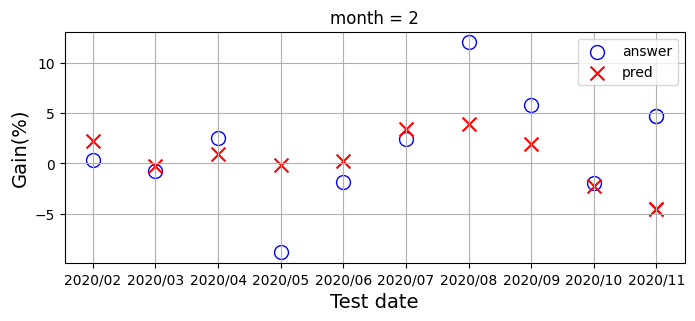

1/1 [==============================] - 0s 14ms/step


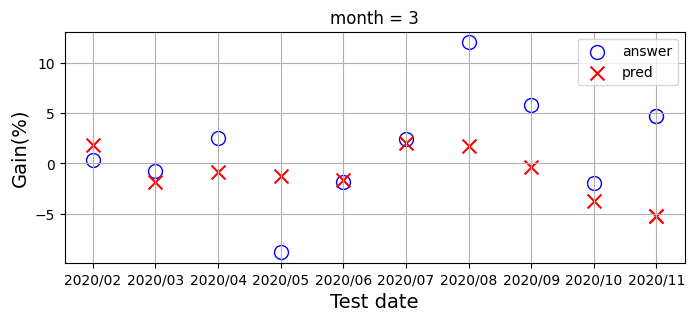

1/1 [==============================] - 0s 14ms/step


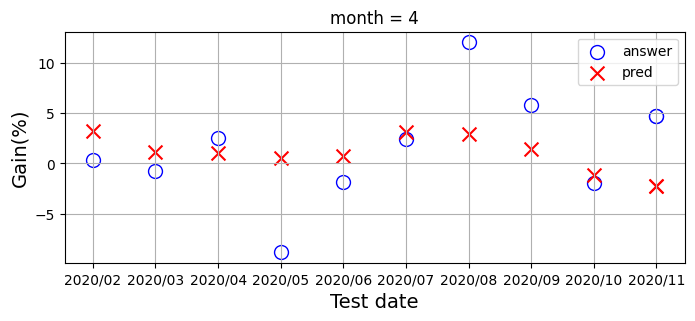

1/1 [==============================] - 0s 15ms/step


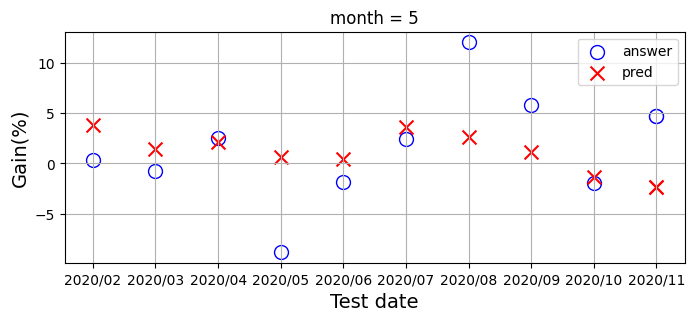

1/1 [==============================] - 0s 18ms/step


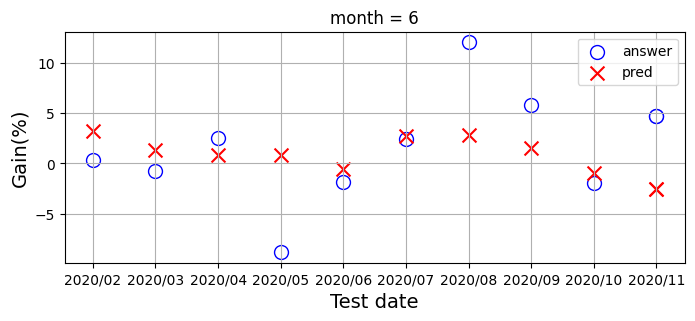

1/1 [==============================] - 0s 27ms/step


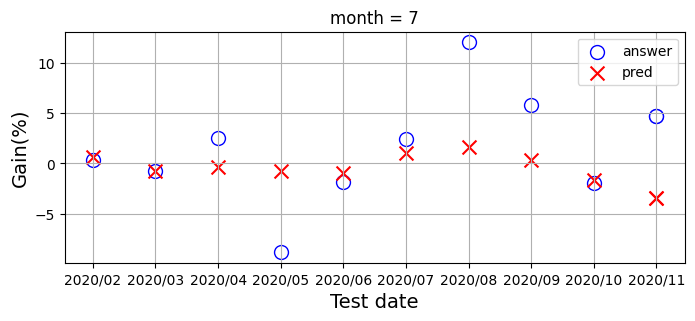

1/1 [==============================] - 0s 30ms/step


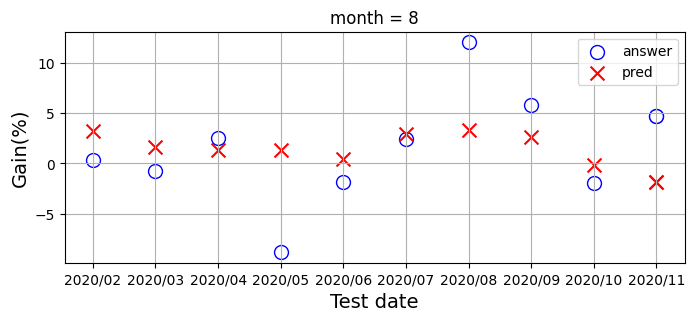

1/1 [==============================] - 0s 26ms/step


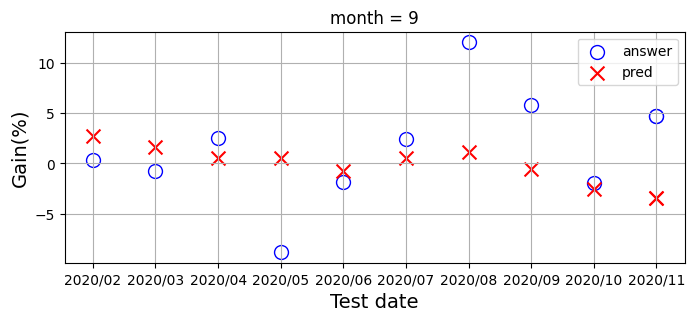

1/1 [==============================] - 0s 22ms/step


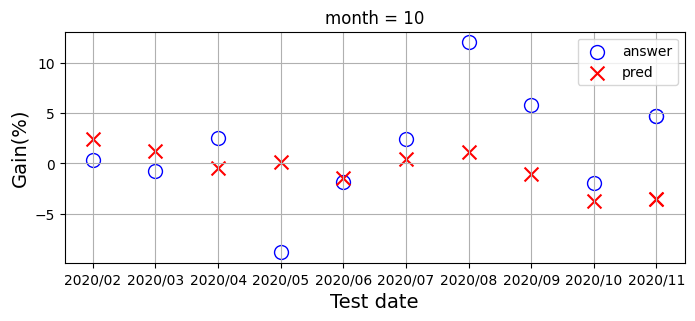

1/1 [==============================] - 0s 37ms/step


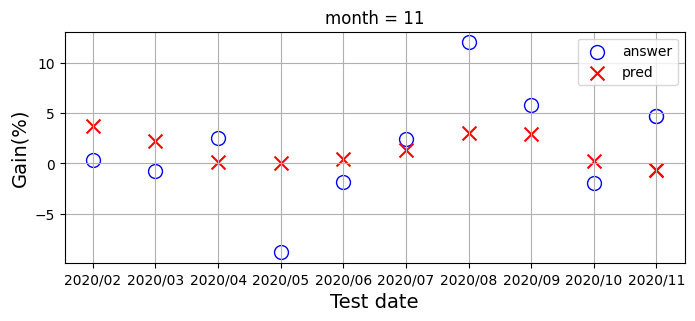

1/1 [==============================] - 0s 33ms/step


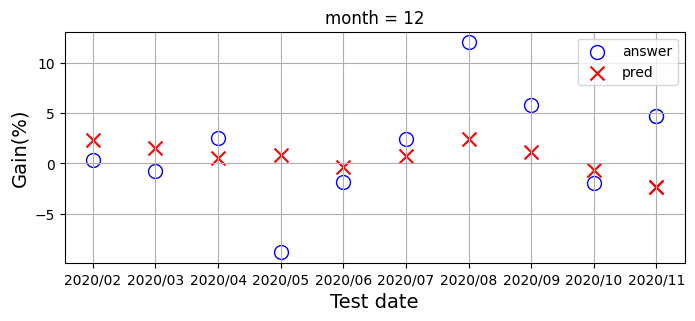

1/1 [==============================] - 0s 115ms/step


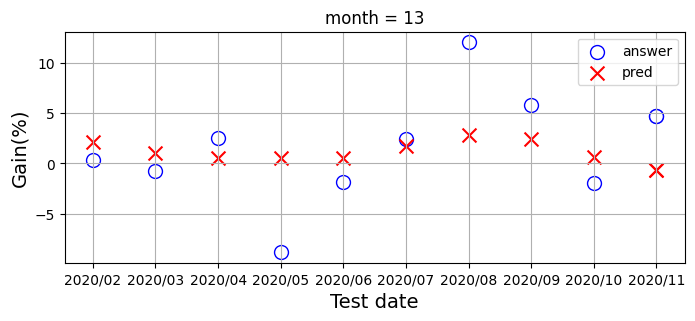

1/1 [==============================] - 0s 20ms/step


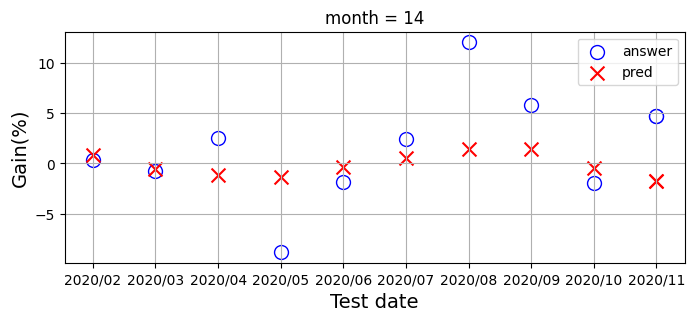

1/1 [==============================] - 0s 22ms/step


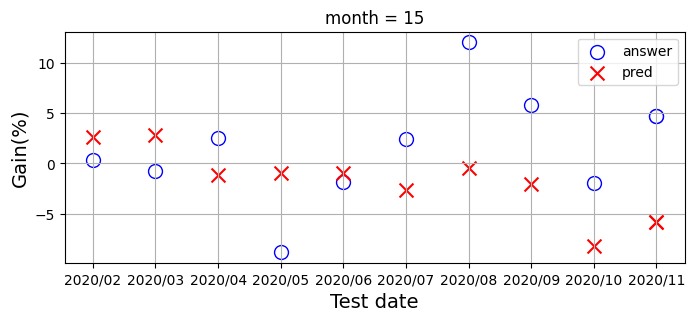

1/1 [==============================] - 0s 34ms/step


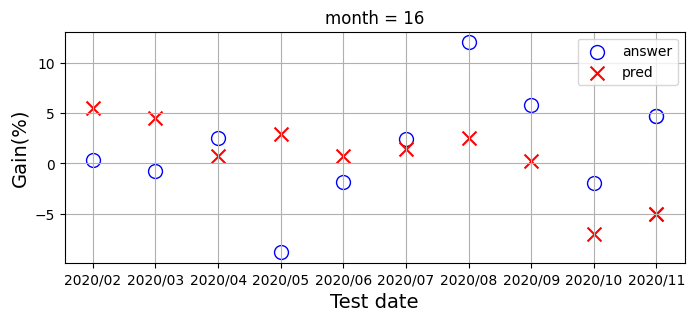

1/1 [==============================] - 0s 53ms/step


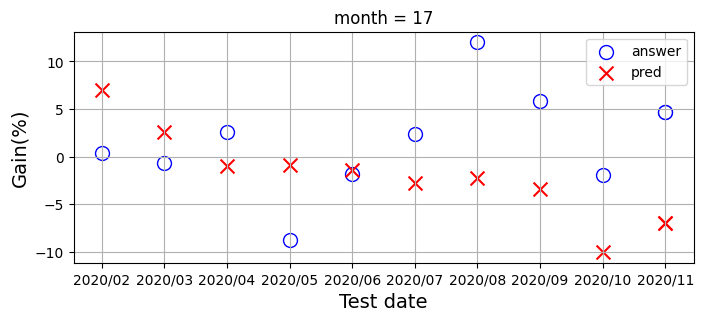

1/1 [==============================] - 0s 59ms/step


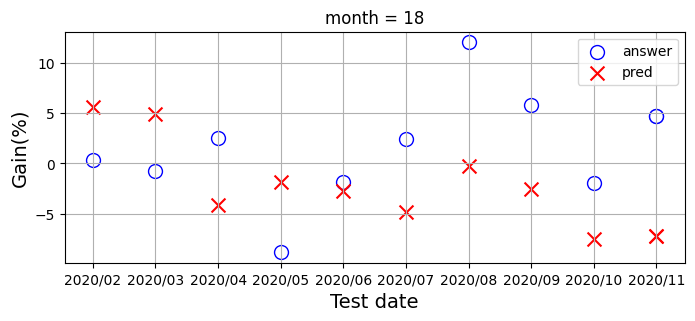

1/1 [==============================] - 0s 50ms/step


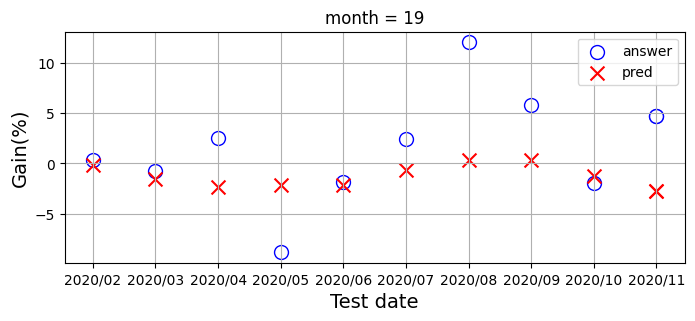

1/1 [==============================] - 0s 34ms/step


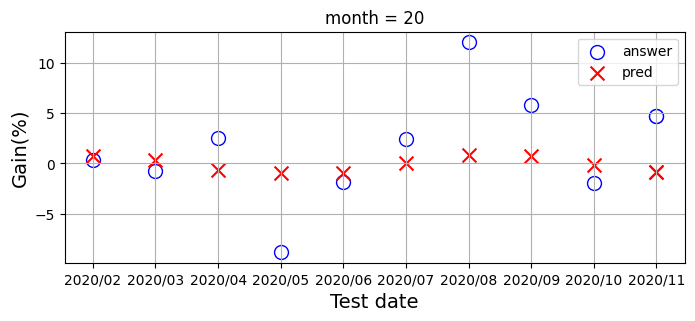

1/1 [==============================] - 0s 41ms/step


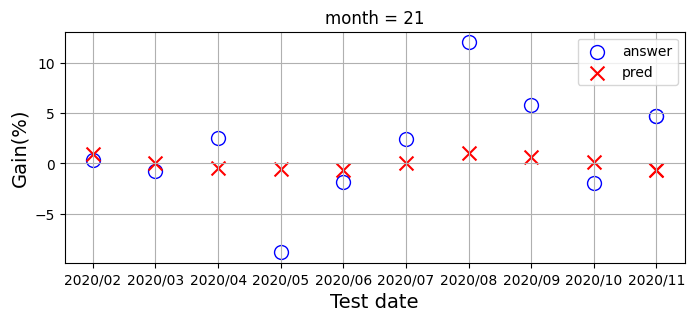

1/1 [==============================] - 0s 63ms/step


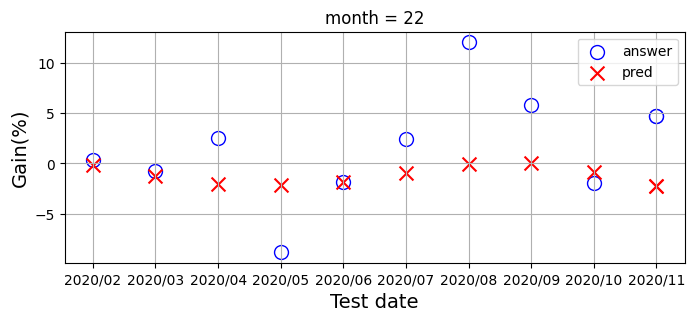

1/1 [==============================] - 0s 57ms/step


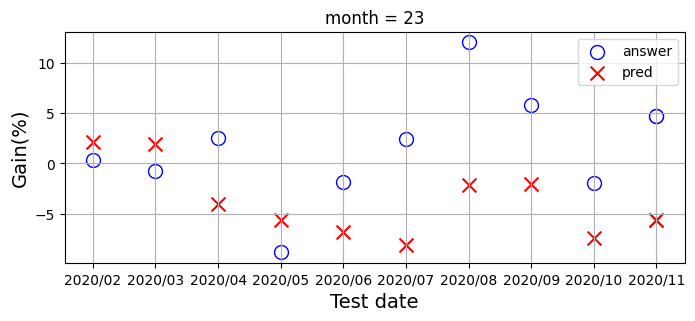

1/1 [==============================] - 0s 76ms/step


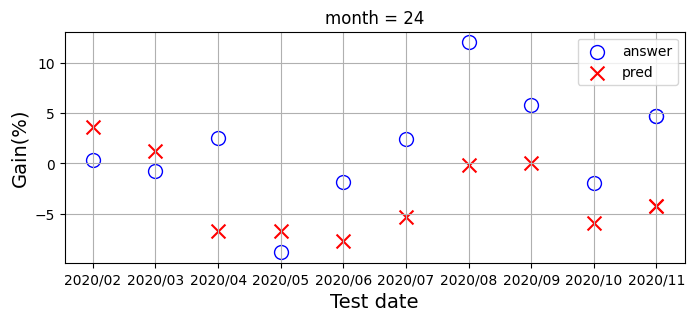

In [120]:

dir = "./results/RNN4_True_85_"
dir2 ="_last_month"
STEPS = list(range(1, 25))
# STEPS = [24]
val_mse_rnn_4_last_month = list()

# target_dir = f"{SAVE_DIR}RNN{num_middle}_{S}_graf/"

for S in STEPS:

    # target_dir = f"{SAVE_DIR}RNN{num_middle}_{return_sequence}_{batch_size}_{S}_graf/"
    # if os.path.exists(f"{target_dir}history.json"):
    #     continue
    # if not os.path.exists(target_dir):
    #     os.mkdir(target_dir)

    tmp_train_inputs = train_inputs[:, -S:, :]
    tmp_train_teacher_signals = train_teacher_signals[:, -S:]
    tmp_test_inputs = test_inputs[:, -S:, :]
    tmp_test_teacher_signals = test_teacher_signals[:, -S:]

    model = models.load_model(f"{dir}{S}{dir2}/model.h5", {"MyMetric" : MyMetric()})
    preds = model.predict(tmp_test_inputs)
    if S == 3:
        a = preds
    else:
        b = preds

    tmp = list()
    for i, TI in enumerate(test_index):
        tmp.append([f'{csgo_datas[TI]["year"]}/{csgo_datas[TI]["month"]:02}', i])
    tmp = list(sorted(tmp, key = lambda T : T[0]))

    p = model.predict(tmp_test_inputs, batch_size = len(tmp_test_inputs))
    p = p * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    p = p[:, -1, 0]
    t = tmp_test_teacher_signals * std_csgo["gain_percent"] + mean_csgo["gain_percent"]
    t = t[:, -1]

    val_mse_rnn_4_last_month.append( losses.MeanSquaredError()(p, t) )

    
    fig = plt.figure(figsize = (8, 3))
    ax = fig.add_subplot()
    for i, (_, I) in enumerate(tmp):

        # ax.scatter(i, t[I], color = "blue", marker='o', alpha=0.8, s=100)
        ax.scatter(i, t[I], s=100, alpha=1, linewidths=1, c='white', edgecolors='b')
        # ax.scatter(i, t[I], color = "blue")
        ax.scatter(i, p[I], color = "red", marker = "x", s = 100)
    
    ax.scatter(i, t[I],  s=100, alpha=1, linewidths=1, c='white', edgecolors='b', label = "answer")
    ax.scatter(i, p[I], color = "red", label = "pred", marker = "x", s = 100)
    ax.set_xticks(range(len(p)))
    ax.set_xticklabels([T[0] for T in tmp])
    ax.set_ylabel("Gain(%)", fontsize = 14)
    ax.set_xlabel("Test date", fontsize = 14)
    ax.set_title(f"month = {S}")
    ax.legend()
    ax.grid()
    # plt.close() 
    plt.show()

    

# for i in range(len(p)):
# for i, (_, I) in enumerate(tmp):
#     # Single_sa.append(abs(p[I] - t[I]))
#     print(f"誤差{i}番目:{abs(p[I] - t[I])}")